This notebook aims at showing a run of the method using residual trajectories generated on the fly, while the code available on the repo to recreate each figures uses precomputed results obtained on 2000 residual trajectories. 

Using 400 residual trajectories, this notebook runs in around 10-12 minutes.

In [1]:
import time
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle as pkl
import seaborn as sns

from scipy.integrate import odeint
from matplotlib.lines import Line2D

plt.rcParams.update({'font.size': 24,
                     'legend.fancybox': True,
                     'legend.fontsize': 25,
                     'axes.spines.right': False,
                     'axes.spines.top': False,
                     'axes.labelsize': 18,
                     'xtick.labelsize': 18,
                     'ytick.labelsize': 18})

# Liver clock model fitted to MMh-D3 hepatocytes data

![](clock_model.png)

The computation of residual trajectories described in Section 3.4 relies on a cellular circadian clock model presented in Section 3.3. Through equations 6 and 7, the parameters of this clock model are involved as well as some protein species timecourse obtained by model simulation.

To circumvent the lack of constraint on the protein variables of the model, we used 10 different parameter sets. All these sets led to a similar fit of the MMh-D3 hepatocytes clock genes mRNA expression. These parameter sets are compared here as well as their induced model simulation.

In [2]:
# load the 10 parameter sets obtained through CMA-ES runs.
param_sets = np.loadtxt('dat/param_sets.txt')

list_params = ['dx{}'.format(i) for i in [1, 2, 5, 6]] + \
              ['dy{}'.format(i) for i in range(1, 7)] + \
              ['dz{}'.format(i) for i in [1, 2, 5, 6, 7, 8]] + \
              ['kfz9', 'kdz9', 'kfz4', 'kdz4'] + \
              ['V{}max'.format(i) for i in [1, 2, 5]] + \
              ['kt1', 'ki1', 'kt2', 'ki2', 'ki21', 'kt3', 'ki3', 'kt4', 'ki4', 'kt5', 'ki5', 'kt6', 'ki6'] + \
              ['kp{}'.format(i) for i in range(1, 7)] + ['kiz{}'.format(i) for i in [4, 6, 7, 9]] + \
              ['fold_per', 'fold_cry', 'fold_rev', 'fold_ror', 'fold_clock'] + \
              ['hill_inhi', 'hill_acti', 'hill_inhi_cry', 'hill_acti_cry', 'hill_inhi_cry_rev'] + \
              ['V{}max'.format(i) for i in [3, 4, 6]]

Chosing  as reference the first parameter set to express all the other parameters sets, let's see how different these sets are. Parameter description and units are provided in the S1 file.

In [3]:
relative_param_sets = param_sets / param_sets[0]
idx_params = np.arange(0, relative_param_sets.shape[1], 1)
nsets = len(param_sets)

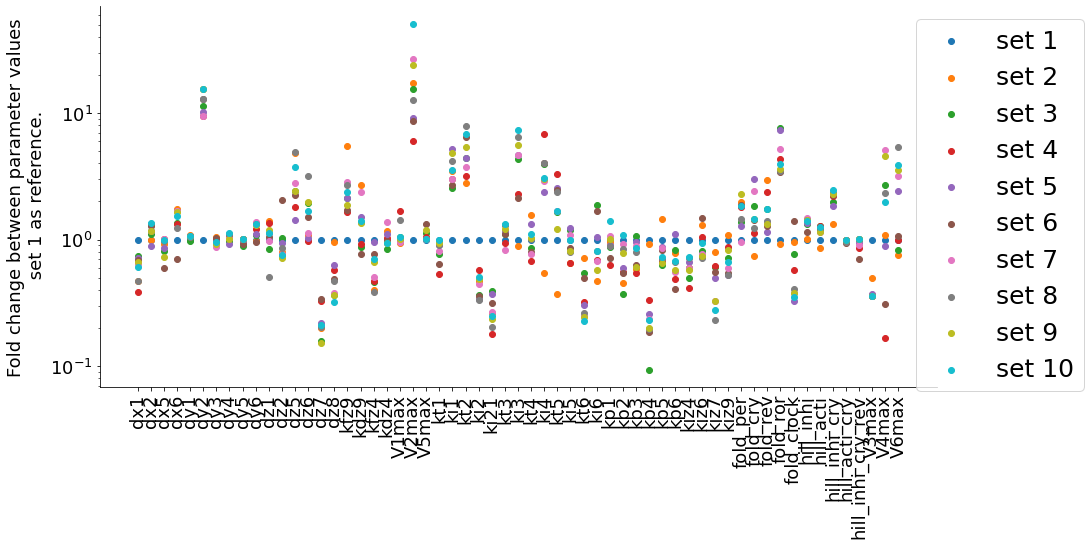

In [4]:
plt.figure(figsize=(15, 7))
for p in range(nsets):
    plt.scatter(idx_params, relative_param_sets[p], label=f'set {p+1}')
plt.legend(bbox_to_anchor=(.96, 1))
plt.xticks(idx_params, list_params, rotation=90)
plt.yscale('log')
plt.ylabel('Fold change between parameter values\n set 1 as reference.')
plt.show()

Differences range from 1 to 10 fold. One should notice that the mRNA degradation parameter $(d_{y_i})_{1\leqslant i \leqslant 6}$ are among the least varying parameters, as expected since the available data for fitting is comprised of gene mRNA expression.

Similarly, what about the species concentrations outputted by the model
for each of the 10 parameter sets?

In [5]:
from algorithm import clock_model_vitro

In [6]:
tplot =601
t = np.linspace(0, 600, 6001)
y0 = np.loadtxt('dat/y0.txt')
list_species = ['CLOCK/BMAL_N', 'PER/CRY^{tot}_N', 'REV-ERB_N', 'ROR_N'] + \
               ['Per', 'Cry', 'Rev-erb', 'Ror', 'Bmal'] + \
               ['CRY_C', 'PER^{tot}_C', 'PER/CRY^{tot}_C', 'CLOCK_C', 'REV-ERB_C', 'ROR_C'] + \
               ['BMAL_C', 'CLOCK/BMAL_C', 'Clock']

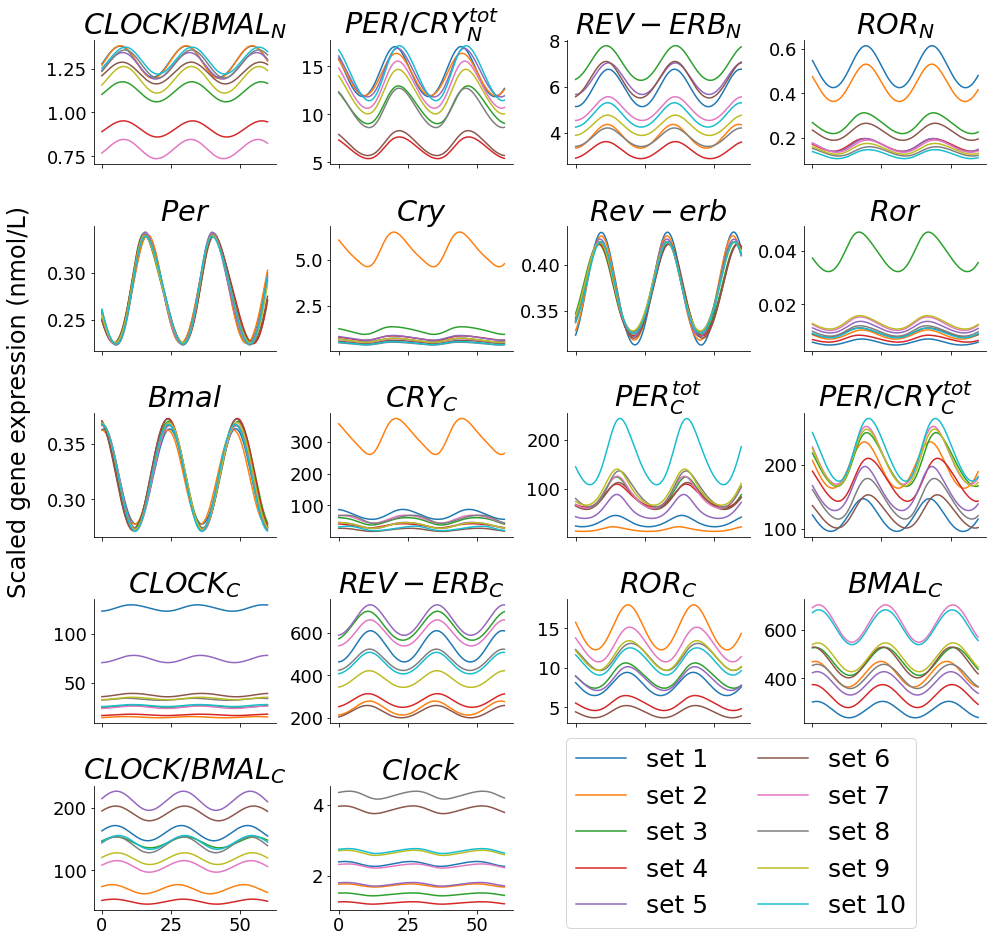

In [7]:
fig, axes = plt.subplots(5, 4, figsize=(16, 16), sharex=True)
fig.subplots_adjust(wspace=.3, hspace=.5,)
Y_sets = []
for p in range(nsets):
    Y = odeint(clock_model_vitro, y0, t, args=(param_sets[p, :],), rtol=10**(-12), atol=10**(-12))
    Y_sets.append(Y[-601:] * 10**9)
    for i, ax in zip(range(len(list_species)), axes.flat):
        ax.plot(t[:tplot], Y_sets[p][:, i],
                label=f'set {p+1}')#,
                #color=colors[i])
        ax.set_title(f'${list_species[i]}$')
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(.85, .285), ncol=2)
fig.text(.05, .4, 'Scaled gene expression (nmol/L)', rotation=90)
fig.delaxes(axes[4, 3])
fig.delaxes(axes[4, 2])
plt.show()

$Bmal$, $Per$ and $Rev-Erb$ have similar curves because:
- Their mRNA expression is fitted by the model
- Absolute concentration levels have been obtained through Q-pcr data in primary hepatocytes as described in main text.

For $Cry$, $Ror$ and $Clock$, only the first point stands. Thus their concentration was allowed to vary at each run. In this case, only the mean level changed, while the phase and relative amplitudes were similar.

The protein species were not constrained. We can see however that the peak phases are quite alike from one run to another.

Finally, we can have a look at all the fits on mRNA expression data for each parameter set.

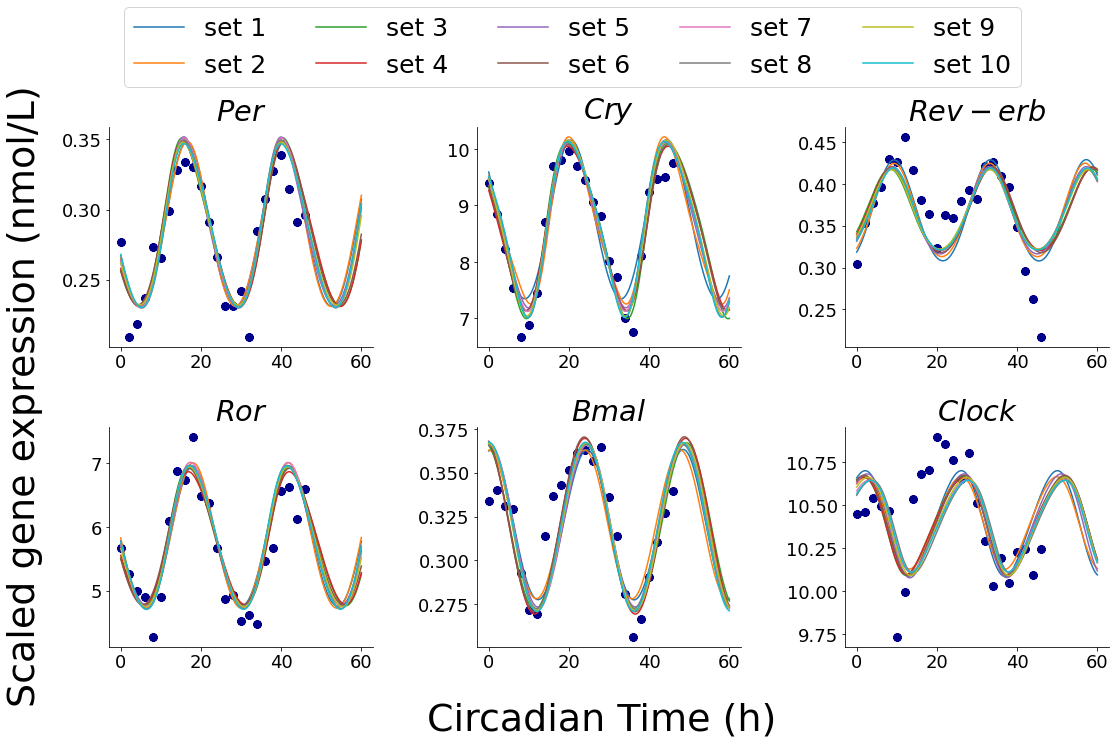

In [8]:
hepato_data = np.loadtxt('dat/invitro_hepato_microarray_mrna_data.txt')
t_data = np.arange(0, 48, 2)
fig, axes = plt.subplots(2, 3, figsize=(16, 9))
fig.text(0, .5, 'Scaled gene expression (nmol/L)',
         ha='center', va='center', rotation='vertical', fontsize=38)
fig.text(.5, 0, 'Circadian Time (h)', ha='center', va='center', fontsize=38)
fig.tight_layout(pad=2)
genes_idx_model = [4, 5, 6, 7, 8, 17]
hepato_data_mean = hepato_data.mean(axis=0)

for p in range(nsets):
    Y_mean = Y_sets[p].mean(axis=0)
    for (i, k), ax in zip(enumerate(genes_idx_model), axes.flat):
        
        ax.scatter(t_data, hepato_data[:, i],
                   marker='o', color='darkblue', s=50)
        ax.plot(t[:601], Y_sets[p][:, k] / Y_mean[k] * hepato_data_mean[i], label=f'set {p+1}')
        ax.set_title(rf'${list_species[k]}$' if p == 9 else None)
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(.875, 1.12), ncol=5)
plt.show()

And we see that indeed, these multiple parameter sets are capable of fitting mRNA expression data while keeping some freedom for the protein expressions, which were not fitted. Again, the only true concentration values are given by $Per$, $Rev-Erb$ and $Bmal$.

# Run of the method

In [9]:
from algorithm import get_residual_trajectories, linreg
from utils import get_graphical_options

options = get_graphical_options()
name_genes = options['names_genes']
name_regs = options['names_biomarkers']
gene_colors = options['colors_genes']
class_colors = options['colors_class']
reg_colors = options['colors_biomarkers']
class_title = options['names_class']
hp = ['Transcription', 'Degradation']
t_res, nclass, ngenes, nhp = 240, len(class_title), len(name_genes), len(hp)

In [10]:
with open('dat/circ_biom.dat', 'rb') as fp:
    data = pkl.load(fp)
# mouse class gene exp data for bmal1, per2 and rev-erbA
genes = data['bmalperrev_GP']
# normalized regulators/integral regulators data for each mouse class
X = data['all_biom_normalized']
nregs = X.shape[2]

## Generate the residual trajectories

Using the circadian clock model defined above, we compute $n_{traj}$ residual trajectories. Specifically, for each of the 10 possible parametrizations of the model, we perform a small perturbation on selected parameter coordinates, and then simulate the models/compute equations (6) and (7). For each of the 10 parametrizations, $\frac{n_{traj}}{10}$ residuals are computed.

In [11]:
# select the number of residual trajectories generated and the seed for 
# parameter perturbation to compute the latter.
ntraj, seed = 400, 56712

start = time.time()
y_transc = get_residual_trajectories(genes, int(ntraj /10), hp='transc', seed=seed)
y_deg = get_residual_trajectories(genes, int(ntraj /10), hp='deg', seed=seed)
end = time.time()
print(f'duration: {np.round(end - start, 2)} seconds')

y = [y_transc, y_deg]

generating residuals from param set n°1 for transc
generating residuals from param set n°2 for transc
generating residuals from param set n°3 for transc
generating residuals from param set n°4 for transc
generating residuals from param set n°5 for transc
generating residuals from param set n°6 for transc
generating residuals from param set n°7 for transc
generating residuals from param set n°8 for transc
generating residuals from param set n°9 for transc
generating residuals from param set n°10 for transc
generating residuals from param set n°1 for deg
generating residuals from param set n°2 for deg
generating residuals from param set n°3 for deg
generating residuals from param set n°4 for deg
generating residuals from param set n°5 for deg
generating residuals from param set n°6 for deg
generating residuals from param set n°7 for deg
generating residuals from param set n°8 for deg
generating residuals from param set n°9 for deg
generating residuals from param set n°10 for deg
duration

We can visualize what these trajectories look like in average:

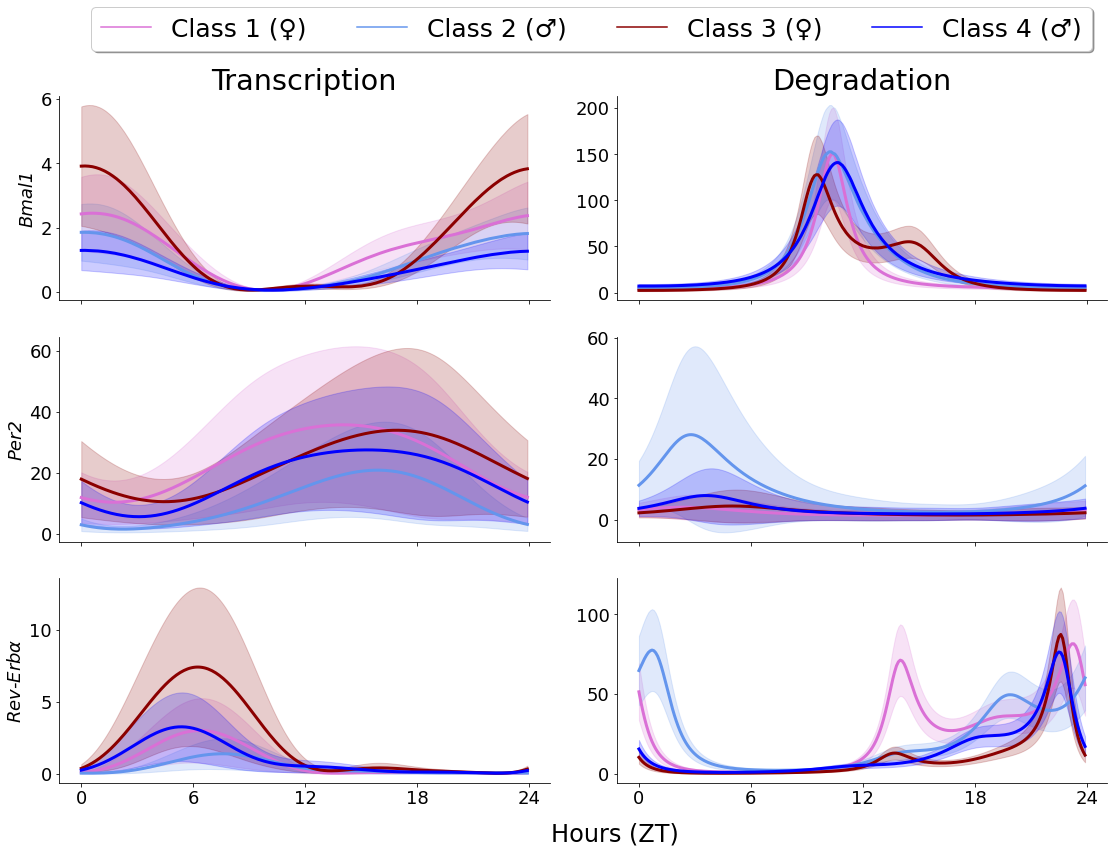

In [12]:
fig, axes = plt.subplots(ngenes, nhp, figsize=(16, 11),
                         sharex=True)
for g in range(ngenes):
    for cl in range(nclass):
        for h in range(nhp):
            axes[g, h].plot(t[:t_res], y[h].mean(axis=0)[g, :, cl],
                            color=class_colors[cl], linewidth=3)
            axes[g, h].fill_between(t[:t_res],
                                    y[h].mean(axis=0)[g, :, cl] - y[h].std(axis=0)[g, :, cl],
                                    y[h].mean(axis=0)[g, :, cl] + y[h].std(axis=0)[g, :, cl],
                                    color=class_colors[cl], alpha=.2)

    for i in range(nhp):
        axes[g, i].set_xticks(np.arange(0, 25, 6))
        axes[0, i].set_title(hp[i])
    axes[g, 0].set_ylabel(name_genes[g], fontstyle='italic')
axes[2, 0].set_ylabel(r'Rev-Erb$\alpha$', fontstyle='italic')
fig.text(.55, 0, 'Hours (ZT)', ha='center', va='center')

# class legend
lines = [Line2D([0], [0], color=c) for c in class_colors]
fig.legend(lines, class_title,
           bbox_to_anchor=(.975, 1.06), shadow=True, ncol=4)

fig.tight_layout()
plt.show()

## Fitting the residual trajectories

We are going to use linear regression to fit each residual trajectories with the systemic regulators. Both the inputs and outputs are normalized so that the weights obtained through linear regression can be compared.

In [13]:
# output normalization. inputs are already normalized
for i in range(nhp):
    y[i] = (y[i] - y[i].mean(axis=2, keepdims=True)) / y[i].std(axis=2, keepdims=True)

Each possible combination of systemic regulators leads to the training of a linear model. However, we ensure that a regulator cannot act in a direct way and in an indirect way through the integral regulator. This leaves us with 242 subsets with 1 to 5 elements per subset.

In [14]:
subsets = list(itertools.chain(*[[i for i in itertools.combinations(range(nregs), j)] for j in range(1, 6)]))
admi_subsets = []
for S in subsets:
    count = 0
    for j in S:
        # features are organized [x_1, ..., x_5, int_x_1, ..., int_x_5]
        if j + 5 in S:
            break
        else:
            count += 1
    # forall j in S, x_j and int_x_j were never present both at the same time 
    if count == len(S):
        admi_subsets.append(S)

We can now start the model fitting step.

In [15]:
W, E = [], []
for i in range(nhp):
    w, err = linreg(X, y[i], admi_subsets)
    W.append(w)
    E.append(err)

Once all models are fitted, the best performing models depending on the number of
systemic regulators involved are gathered for each genes and each hypothesis.

In [16]:
def get_nmodels(n):
    
    """
    Compute the number of possible models involving n regulators when ensuring
    that a regulator is never found twice in a model with its direct and indirect
    action.
    """
    
    return int(1 / np.math.factorial(n) * np.prod([2 * j for j in range(5 - n +1, 6)]))

idx_nmodels = np.cumsum([0] + [get_nmodels(i) for i in range(1, 6)])
mins = np.zeros([nhp, ngenes, ntraj, 5])
for i in range(nhp):
    for j in range(len(idx_nmodels) - 1):
        for g in range(ngenes):
            for n in range(ntraj):
                # mean over mouse class. best model: error minimizer
                mins[i, g, n, j] = E[i][g, n, idx_nmodels[j]:idx_nmodels[j+1], :].mean(axis=1).min()

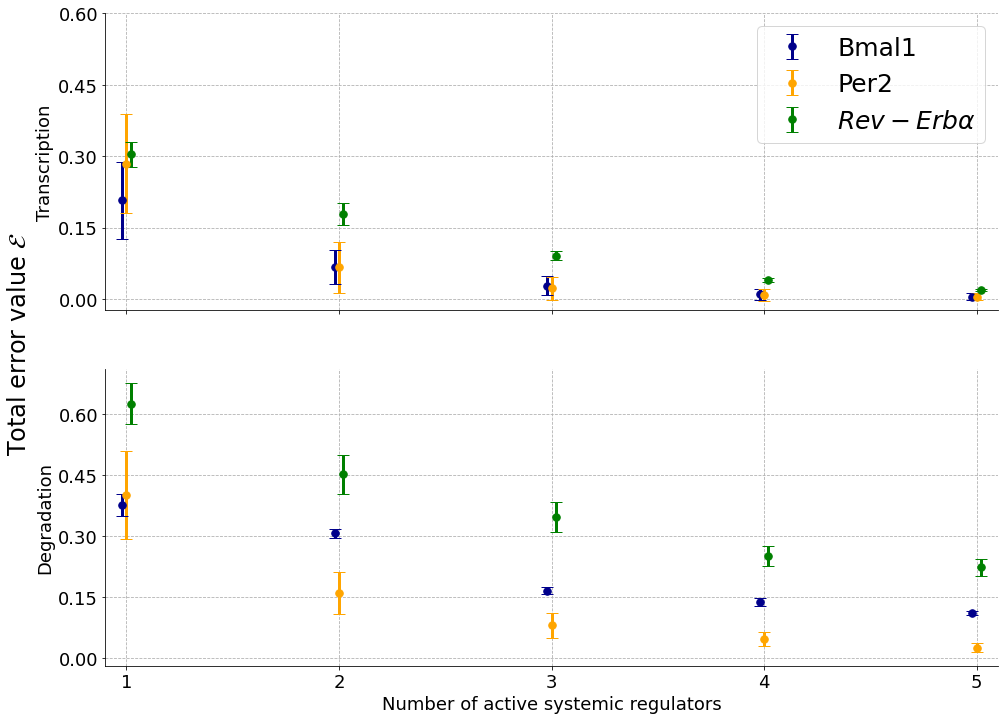

In [17]:
fig, axes = plt.subplots(len(mins), 1, figsize=(16, 12), sharex=True)
plt.subplots_adjust(hspace=.2)
n_coeffs = np.arange(1, 6, 1)
space = [-.02, 0, 0.02]
for i in range(nhp):
    for g in range(ngenes):
        mean = mins[i, g, :, :].mean(axis=0)
        std = mins[i, g, :, :].std(axis=0)

        axes[i].errorbar(n_coeffs + space[g], mean, yerr=std, fmt='.',
                         capsize=6, color=gene_colors[g],
                         markersize=15, elinewidth=3,
                         label=name_genes[g] if g != 2 else r'$Rev-Erb\alpha$')

    axes[i].set_yticks(np.linspace(0, .6, 5))
    axes[i].grid(linestyle='--')
    axes[i].set_xlim(.9, 5.1)
    axes[i].set_ylabel(hp[i])

axes[0].legend(bbox_to_anchor=(1, 1))
axes[1].set_xticks(n_coeffs)
axes[1].set_xlabel('Number of active systemic regulators')
fig.text(.04, .375, r'Total error value $\mathcal{E}$', rotation=90)
plt.show()

Focusing on 2-terms models for the transcription, we obtain:

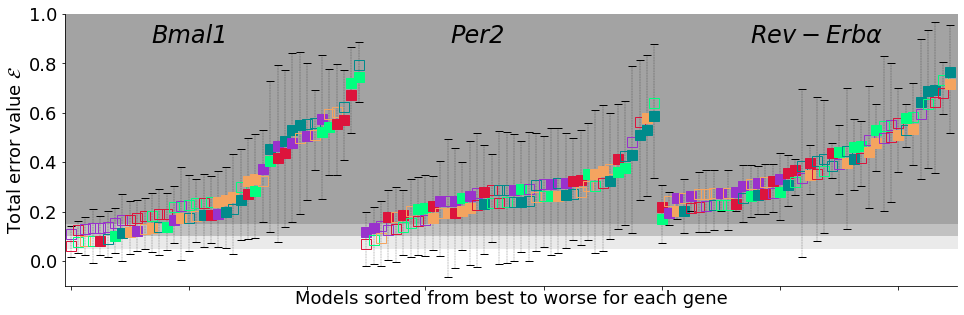

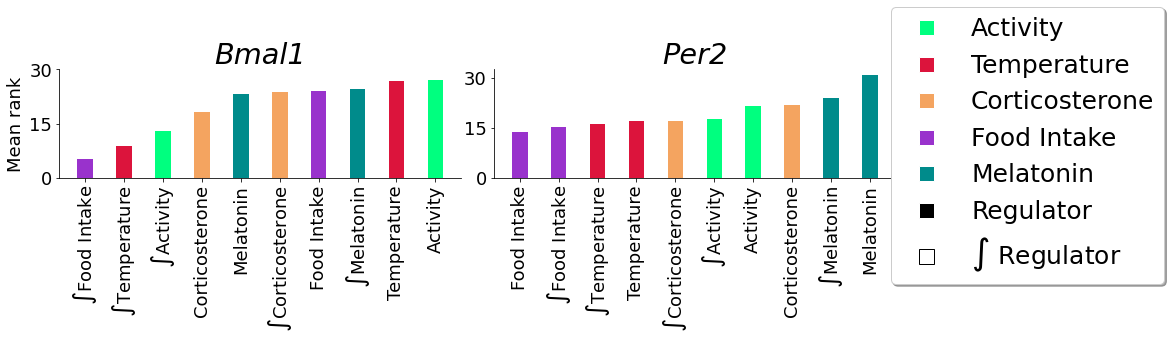

In [18]:
# initialize dict to store systemic regulators ranks

feats = name_regs + ['$\int$' + f for f in name_regs]
nfeats = len(feats)
regsets = admi_subsets[10:50]
ranks = {}
for n in name_genes:
    ranks[n] = {}
    for f in feats:
        ranks[n][f] = []
mean_ranks = np.zeros([ngenes, nfeats])

# figure generated only in the transcription case
coeffs_2 = np.abs(W[0][:, :, idx_nmodels[1]:idx_nmodels[2], :, :]).mean(axis=(1, 3))
mean_2 = E[0][:, :, idx_nmodels[1]:idx_nmodels[2], :].mean(axis=(1, 3))
std_2 = E[0][:, :, idx_nmodels[1]:idx_nmodels[2], :].std(axis=(1, 3))

fig, axes = plt.subplots(figsize=(16, 5))
first_model = np.zeros([ngenes, 2], dtype=np.int32)
first_model_idx = []
for g in range(ngenes):
    sort = np.argsort(mean_2[g])
    for l, k in enumerate(sort):
        idx = np.argsort(coeffs_2[g, k])[::-1][:2]
        eb = axes.errorbar(l * 1.25 + g * 50, mean_2[g, k], std_2[g, k],
                           fmt='none', capsize=4, color='black', elinewidth=.25)
        eb[-1][0].set_linestyle('-.')

        plt.plot(l * 1.25 + g * 50, mean_2[g, k] - .02, markersize=10, marker='s',
                 c=reg_colors[idx[1] % 5],
                 markerfacecolor=reg_colors[idx[1] % 5] if idx[1] < 5 else 'none')

        plt.plot(l * 1.25 + g * 50, mean_2[g, k] + .03, markersize=10, marker='s',
                 c=reg_colors[idx[0] % 5],
                 markerfacecolor=reg_colors[idx[0] % 5] if idx[0] < 5 else 'none')
        
        #collect systemic regulators ranks
        ranks[name_genes[g]][feats[regsets[k][0]]].append(l)
        ranks[name_genes[g]][feats[regsets[k][1]]].append(l)

        # collect regulators involved for best model
        if not l:
            first_model[g, :] = [idx[0], idx[1]]
            first_model_idx.append(10 + k)
        
    # mean rank computation for each regulator
    for f, r in enumerate(ranks[name_genes[g]].values()):
        mean_ranks[g, f] = np.mean(r)

    fig.text(.2 + .26 * g, .8,
             name_genes[g] if g != 2 else r'$Rev-Erb\alpha$', fontstyle='italic')
plt.setp(axes.get_xticklabels(), visible=False)
plt.ylabel(r'Total error value $\mathcal{E}$')
plt.ylim(-.1, 1)
plt.xlim(-1, 150)
plt.axhspan(.15, 1, facecolor='0.2', alpha=0.45)
plt.axhspan(.10, .15, facecolor='0.2', alpha=0.3)
plt.axhspan(.05, .1, facecolor='0.2', alpha=0.1)
plt.xlabel('Models sorted from best to worse for each gene')

# repartition of regulators in selected best models
fig, axes = plt.subplots(1, 2, figsize=(15, 2))
fig.subplots_adjust(wspace=.08)
for g in range(ngenes - 1):
    idx_sorted = np.argsort(mean_ranks[g])
    for l in range(len(idx_sorted)):
        axes[g].bar(l, mean_ranks[g][idx_sorted[l]],
                    color=reg_colors[idx_sorted[l] % 5], width=.4)

    axes[g].set_xticks(np.arange(len(idx_sorted)))
    axes[g].set_xticklabels([feats[p] for p in idx_sorted], rotation=90)
    axes[g].set_title(name_genes[g], fontstyle='italic')
    axes[g].set_yticks(np.arange(0, 31, 15))

lines = [Line2D([0], [0], color='w', markerfacecolor=c,
         marker='s', markersize=15) for c in reg_colors] + \
        [Line2D([0], [0], color='w', markerfacecolor='black',
         marker='s', markersize=15)] + \
        [Line2D([0], [0], color='w', markeredgecolor='black',
         marker='s', markersize=15, linestyle='--')]
axes[0].set_ylabel('Mean rank')
labels = ['Regulator', '$\int$ Regulator']
fig.legend(lines, name_regs + labels,
           bbox_to_anchor=(1.16, 1.4), shadow=True, ncol=1)
plt.show()

Finally, we can have a look at the weight distribution for the best model for $Bmal1$ and $Per2$ (In the transcription case), the trajectories associated to $Rev-Erb\alpha$ not being sufficiently well fitted.

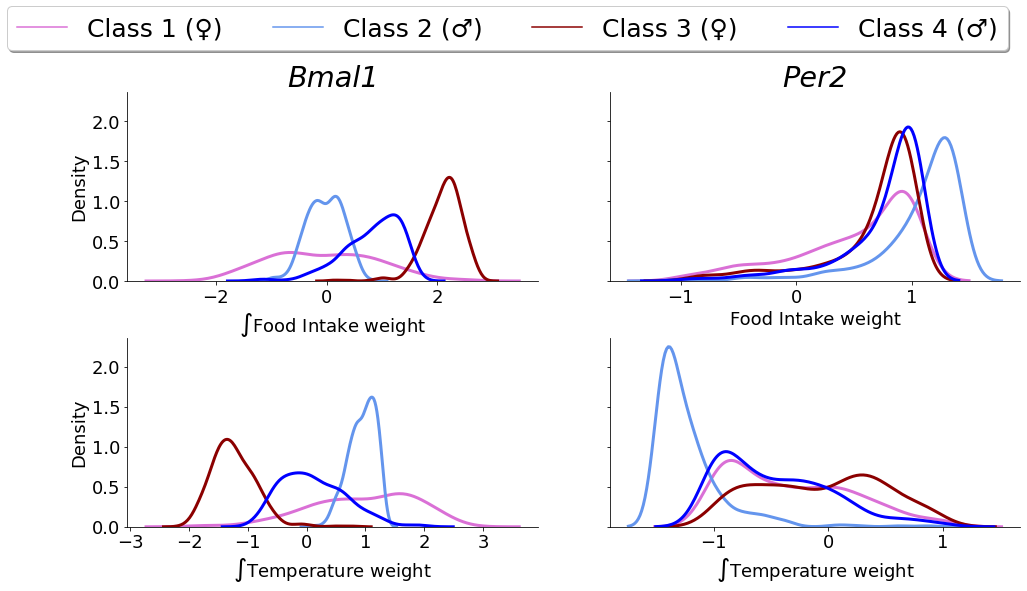

In [19]:
fig, axes = plt.subplots(ngenes - 1, ngenes - 1, figsize=(16, 8), sharey=True)
fig.subplots_adjust(hspace=.3, wspace=.175)
for i in range(nclass):
    sns.kdeplot(W[0][0, :, first_model_idx[0], i, first_model[0, 0]],
                ax=axes[0, 0], color=class_colors[i],
                linewidth=3)
    axes[0, 0].set_xlabel(fr'{feats[first_model[0, 0]]} weight')

    sns.kdeplot(W[0][0, :, first_model_idx[0], i, first_model[0, 1]],
                ax=axes[1, 0], color=class_colors[i],
                linewidth=3)
    axes[1, 0].set_xlabel(fr'{feats[first_model[0, 1]]} weight')

    sns.kdeplot(W[0][1, :, first_model_idx[1], i, first_model[1, 0]],
                ax=axes[0, 1], color=class_colors[i],
                linewidth=3)
    axes[0, 1].set_xlabel(fr'{feats[first_model[1, 0]]} weight')

    sns.kdeplot(W[0][1, :, first_model_idx[1], i, first_model[1, 1]],
                ax=axes[1, 1], color=class_colors[i],
                linewidth=3)
    axes[1, 1].set_xlabel(fr'{feats[first_model[1, 1]]} weight')

# class legend
[axes[0, i].set_title(name_genes[i], fontstyle='italic') for i in range(2)]
lines = [Line2D([0], [0], color=c) for c in class_colors]
fig.legend(lines, class_title,
           bbox_to_anchor=(.9, 1.05), shadow=True,
           ncol=nclass)
plt.show()